In [41]:
import csv 
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot 
%matplotlib inline

## Part 1

In [42]:
#load main airfoil geometry
with open ('MainFoil_N=50.csv') as infile:
    airfoil_main = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_main = numpy.empty((len(airfoil_main),1))
y_main = numpy.empty((len(airfoil_main),1))

for i in range(0, len(airfoil_main)):
    x_main[i] = airfoil_main[i, 0]
    y_main[i] = airfoil_main[i, 1]
    
#load flap geometry 
with open ('FlapFoil_N=100.csv') as infile:
    airfoil_flap = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_flap = numpy.empty((len(airfoil_flap),1))
y_flap = numpy.empty((len(airfoil_flap),1))

for i in range(0, len(airfoil_flap)):
    x_flap[i] = airfoil_flap[i, 0]
    y_flap[i] = airfoil_flap[i, 1]
    

(-0.25, 0.15)

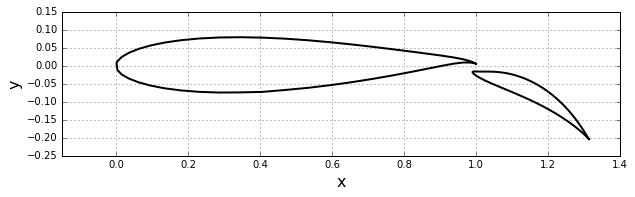

In [50]:
#plot airfoil 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.25,0.15)

In [5]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya #panel start 
        self.xb, self.yb = xb, yb #panel end
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 #panel center 
        self.length = numpy.sqrt((xb-xa)**2 + (yb-ya)**2) #panel length
        
        #angle between x axis and panel's normal - orientation 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        #panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface 
            
        self.sigma = 0.0 #strength of source
        self.vt = 0.0 #tangential velocity 
        self.cp = 0.0 #pressure coeff

In [9]:
def define_panels(x, y, N):
    
    x_ends, y_ends = x, y 
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [52]:
Nm = len(x_main)-1
Nf = len(x_flap)-1

panels_main = define_panels(x_main, y_main, Nm)
panels_flap = define_panels(x_flap, y_flap, Nf)

(-0.25, 0.15)

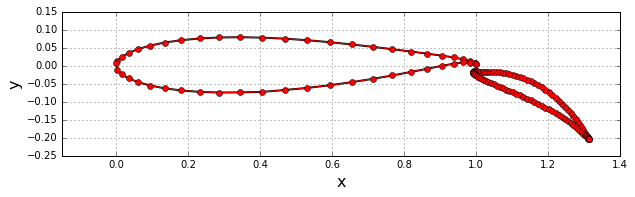

In [53]:
width=10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)

pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa), 
           numpy.append([panel.ya for panel in panels_main], panels_main[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa), 
           numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')

pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.25,0.15)

In [54]:
class Freestream:
    """
    Freestream conditions
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle with the x axis 
        
        u_inf: freestream speed 
        alpha: angle of attack in degrees"""
        
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180

In [55]:
u_inf = 1.0
alpha = 0.0 
freestream = Freestream(u_inf, alpha)

In [56]:
def integral(x, y, panel, dxdz, dydz):
 
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [57]:
def build_matrix(panels):
    """Builds the source matrix 
    panels: the source panels
    A: the source matrix, NxN matrix
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
                
    return A 

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system
    panels: the source panels
    freestream: freestream conditions 
    b: RHS of the linear system"""
    
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
        
    return b

## Part 2

In [67]:
#load main airfoil geometry
with open ('NACA23012_MainFoil.csv') as infile:
    airfoil_main = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_main = numpy.empty((len(airfoil_main),1))
y_main = numpy.empty((len(airfoil_main),1))

for i in range(0, len(airfoil_main)):
    x_main[i] = airfoil_main[i, 0]
    y_main[i] = airfoil_main[i, 1]
    
#load flap geometry 
with open ('NACA23012_FlapFoil.csv') as infile:
    airfoil_flap = numpy.loadtxt(infile, dtype=float, delimiter=',')
    
x_flap = numpy.empty((len(airfoil_flap),1))
y_flap = numpy.empty((len(airfoil_flap),1))

for i in range(0, len(airfoil_flap)):
    x_flap[i] = airfoil_flap[i, 0]
    y_flap[i] = airfoil_flap[i, 1]

(-0.07, 0.09)

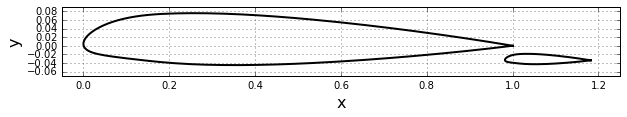

In [68]:
#plot airfoil 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.05, 1.25)
pyplot.ylim(-0.07,0.09)

In [69]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya #panel start 
        self.xb, self.yb = xb, yb #panel end
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 #panel center 
        self.length = numpy.sqrt((xb-xa)**2 + (yb-ya)**2) #panel length
        
        #angle between x axis and panel's normal - orientation 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        #panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface 
            
        self.sigma = 0.0 #strength of source
        self.vt = 0.0 #tangential velocity 
        self.cp = 0.0 #pressure coeff

In [70]:
def define_panels(x, y, N):
    
    x_ends, y_ends = x, y 
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [71]:
Nm = len(x_main)-1
Nf = len(x_flap)-1

panels_main = define_panels(x_main, y_main, Nm)
panels_flap = define_panels(x_flap, y_flap, Nf)

In [72]:
#width=10
#pyplot.figure(figsize=(width, width))
#pyplot.grid()
#pyplot.xlabel('x', fontsize=16)
#pyplot.ylabel('y', fontsize=16)

#pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
#pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)

#pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa), 
           #numpy.append([panel.ya for panel in panels_main], panels_main[0].ya), 
           #linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
#pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa), 
           #numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya), 
           #linestyle='-', linewidth=1, marker='o', markersize=6, color='r')

#pyplot.axis('scaled', adjustable='box')
#pyplot.xlim(-0.05, 1.5)
#pyplot.ylim(-0.1, 0.1)

In [73]:
class Freestream:
    """
    Freestream conditions
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle with the x axis 
        
        u_inf: freestream speed 
        alpha: angle of attack in degrees"""
        
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180

In [74]:
u_inf = 1.0
alpha = 0.0 
freestream = Freestream(u_inf, alpha)

In [ ]:
#use bisection method to determine the angle of attack that will cause zero lift 
#when the flap angle is 20 degrees